In [1]:
from raspberry_listener.datatypes import Sensor, SensorData, SensorReading, SensorType
from raspberry_listener.remotereader import download_archive
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
import numpy as np
from functools import partial

In [2]:
archive = download_archive()

In [3]:
sensor_combinations = {"humidity": ["DHT11"], "temperature": ["DHT11","PI_CPU", "DS18B20"]}

In [4]:
df = pl.read_parquet(archive)
print(df)

shape: (3_911_868, 5)
┌─────────────┬────────┬────────────────────────────┬─────────┬──────┐
│ sensor_type ┆ sensor ┆ timestamp                  ┆ reading ┆ unit │
│ ---         ┆ ---    ┆ ---                        ┆ ---     ┆ ---  │
│ str         ┆ str    ┆ datetime[ns]               ┆ f64     ┆ str  │
╞═════════════╪════════╪════════════════════════════╪═════════╪══════╡
│ temperature ┆ DHT11  ┆ 2023-05-09 02:25:04.813177 ┆ 23.0    ┆ C    │
│ temperature ┆ DHT11  ┆ 2023-05-09 02:25:06.091469 ┆ 23.0    ┆ C    │
│ temperature ┆ DHT11  ┆ 2023-05-09 02:25:07.320726 ┆ 23.0    ┆ C    │
│ temperature ┆ DHT11  ┆ 2023-05-09 02:25:08.321924 ┆ 23.0    ┆ C    │
│ …           ┆ …      ┆ …                          ┆ …       ┆ …    │
│ humidity    ┆ DHT11  ┆ 2023-05-25 22:15:59.522674 ┆ 35.0    ┆ %    │
│ humidity    ┆ DHT11  ┆ 2023-05-25 22:16:00.523243 ┆ 35.0    ┆ %    │
│ humidity    ┆ DHT11  ┆ 2023-05-25 22:16:01.538681 ┆ 35.0    ┆ %    │
│ humidity    ┆ DHT11  ┆ 2023-05-25 22:16:02.540225 ┆ 3

In [16]:
def time_of_day(df: pl.DataFrame, sensor_type, sensor):
    def get_timesorted_single_sensor(df: pl.DataFrame) -> tuple[pl.DataFrame, str]:
        single_sensor_df = df.lazy().filter(pl.col("sensor_type").is_in([sensor_type]) & pl.col("sensor").is_in([sensor]))
        return single_sensor_df.sort("timestamp").collect(), df.item(row=0, column="unit")
    def get_counts(df: pl.DataFrame):
        def get_count(array, bins):
            count, _ = np.histogram(array, bins=bins, density=True)
            return count
        _, bins = np.histogram(df.select("reading").to_series().view())
        grouping = df.groupby(df.select(pl.col("timestamp").dt.hour()))
        # binned_count = partial(get_count, bins=bins)
        # out = grouping.agg(pl.col("reading").apply(binned_count))
        counts = [(_,get_count(group.select("reading").to_series().view(), bins)) for _,group in grouping]
        counts.sort(key=lambda x:x[0])
        counts = [count[1] for count in counts]
        return np.array(counts), bins
    def plot_clock(counts, bins, ax, **kwargs):
        """Plot a single radial stacked barplot showing the temperature density for the hour.
        We are stacking bar plots on top of each other in a polar projection. x is the angle-value the bar starts at. It extends a constant angle width, which is 360 degrees/24, or 2pi radians/24.
        Bottom means where is the bottom of the bar we are plotting. It should be at the top of the previous bar we plotted, or 0 if it's the first bar.
        The height of the bar is the count we found for the bin. Each bar represents one of the bins.
        All bars have a constant width, which is equal to 360 degrees // 24, or 2pi/24 radians"""
        bottom = np.zeros(24)
        for i, _ in enumerate(bins[:-1]):
            theta = np.linspace(0, 2 * np.pi, 24, endpoint=False)
            width = theta[1] - theta[0]
            height = counts.T[i]
            ax.bar(
                x=theta,
                height = height,
                width = width,
                bottom = bottom,
                align="edge",
                label=f"{bins[i]} - {bins[i+1]}",
                **kwargs,
            )
            bottom += height
        angle_step = 360 // 24
        angles = [(i * angle_step) for i in range(24)]
        labels = range(24)
        ax.set_thetagrids(angles, labels)
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.yaxis.set_major_formatter(mpl.ticker.NullFormatter())

    df, unit = get_timesorted_single_sensor(df)
    counts, bins = get_counts(df)
    _, ax = plt.subplots(subplot_kw={"projection":"polar"})
    plot_clock(counts, bins, ax)
    # ax.legend()
    ax.set_title(f"{sensor_type} - {sensor}")
    

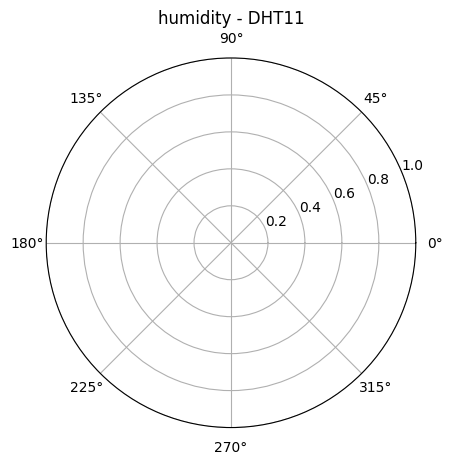

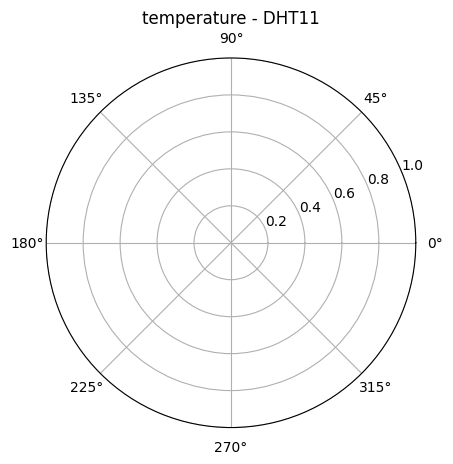

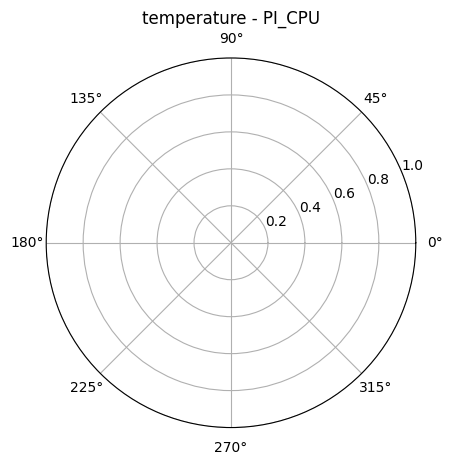

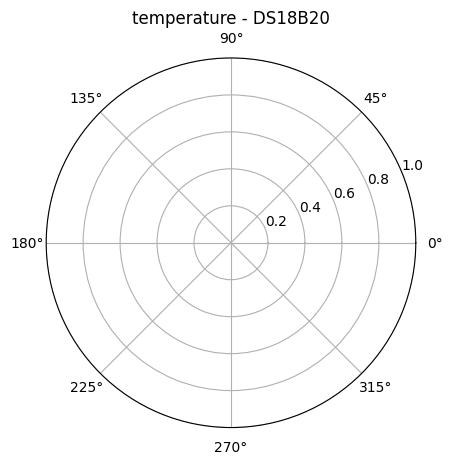

         304896 function calls (295200 primitive calls) in 0.680 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      120    0.328    0.003    0.328    0.003 {method 'collect' of 'builtins.PyLazyFrame' objects}
       96    0.135    0.001    0.135    0.001 {method 'take_with_series' of 'builtins.PyDataFrame' objects}
       96    0.045    0.000    0.045    0.000 {method 'sort' of 'numpy.ndarray' objects}
      100    0.015    0.000    0.078    0.001 histograms.py:678(histogram)
     4948    0.007    0.000    0.008    0.000 transforms.py:194(set_children)
 1560/640    0.006    0.000    0.083    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      512    0.005    0.000    0.005    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     4424    0.003    0.000    0.010    0.000 transforms.py:2347(__init__)
     1212    0.003    0.000    0.016    0.000 artist.py:1180(_update_props)
10108/9116    0.0

In [17]:
def plot_all():
    for sensor_type, sensors in sensor_combinations.items():
        for sensor in sensors:
            time_of_day(df, sensor_type, sensor)
%prun plot_all()
